In [ ]:
library(here)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scales)
library(reticulate)
library(repr)
#library(DoubletFinder)
library(future)
library(RColorBrewer)
library(edgeR)
library(limma)
#library(PCAtools)
options(future.globals.maxSize = 100000 * 1024^2)
source(here("R_functions","edgeR_function.R"))

annotations = read.csv("R_functions/gene_descriptions.csv", header = F)
colnames(annotations) = c("gene_id", "description")
annotations$gene_id = substr(annotations$gene_id, 1, 9)

proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 1,]$genes)
bulk_data = read.csv("/home/robotmessenger810/data/buckets/single_cell_bucket_3_4_21/IWT_RNA_seq/scRNA_flowers/outputs/bulk_edger_10_16_20.csv")


In [3]:
seu_intd_wt = readRDS(file = "../data/seurat_objects/seurat_WT_intd_2_17_21.rds")
seu_intd_mut = readRDS(file = "../data/seurat_objects/seurat_mut_intd_2_17_22.rds")

In [4]:
cluster = "9"

wt_1_AZ <- subset(seu_intd_wt, subset = orig.ident == "sc_26_combined")[, WhichCells(subset(seu_intd_wt, subset = orig.ident == "sc_26_combined"), ident = cluster)]
wt_2_AZ <- subset(seu_intd_wt, subset = orig.ident == "sc_67")[, WhichCells(subset(seu_intd_wt, subset = orig.ident == "sc_67"), ident = cluster)]
YFP_1_AZ <- subset(seu_intd_wt, subset = orig.ident == "sc_101")[, WhichCells(subset(seu_intd_wt, subset = orig.ident == "sc_101"), ident = cluster)]
YFP_2_AZ <- subset(seu_intd_wt, subset = orig.ident == "sc_103")[, WhichCells(subset(seu_intd_wt, subset = orig.ident == "sc_103"), ident = cluster)]

In [ ]:
wt_1_seu = SCTransform(wt_1_AZ)
wt_2_seu = SCTransform(wt_2_AZ)
YFP_1_seu = SCTransform(YFP_1_AZ)
YFP_2_seu = SCTransform(YFP_2_AZ)

In [ ]:
seu_intd_wt_AZ = seu_integrate(wt_1_seu, wt_2_seu, YFP_1_seu, YFP_2_seu, filename = "AZ_only_WT_3_1_22", nfeatures = 3000)

In [9]:
seu_intd_wt_AZ = readRDS("/home/robotmessenger810/sc_analysis/data/intd_seu_objects/AZ_only_WT_3_1_22.rds")

In [10]:
resolution = .5
set.seed(42)
DefaultAssay(seu_intd_wt_AZ) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
seu_intd_wt_AZ <- ScaleData(seu_intd_wt_AZ, verbose = FALSE)
seu_intd_wt_AZ <- RunPCA(seu_intd_wt_AZ, npcs = 100, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

#previously run 20 PCs as of 2/14/22
seu_intd_wt_AZ <- FindNeighbors(seu_intd_wt_AZ, dims = 1:20, verbose = FALSE)
seu_intd_wt_AZ <- FindClusters(seu_intd_wt_AZ, resolution = resolution, algorithm = 3, verbose = FALSE)
seu_intd_wt_AZ <- RunUMAP(seu_intd_wt_AZ, reduction = "pca", dims = 1:20, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


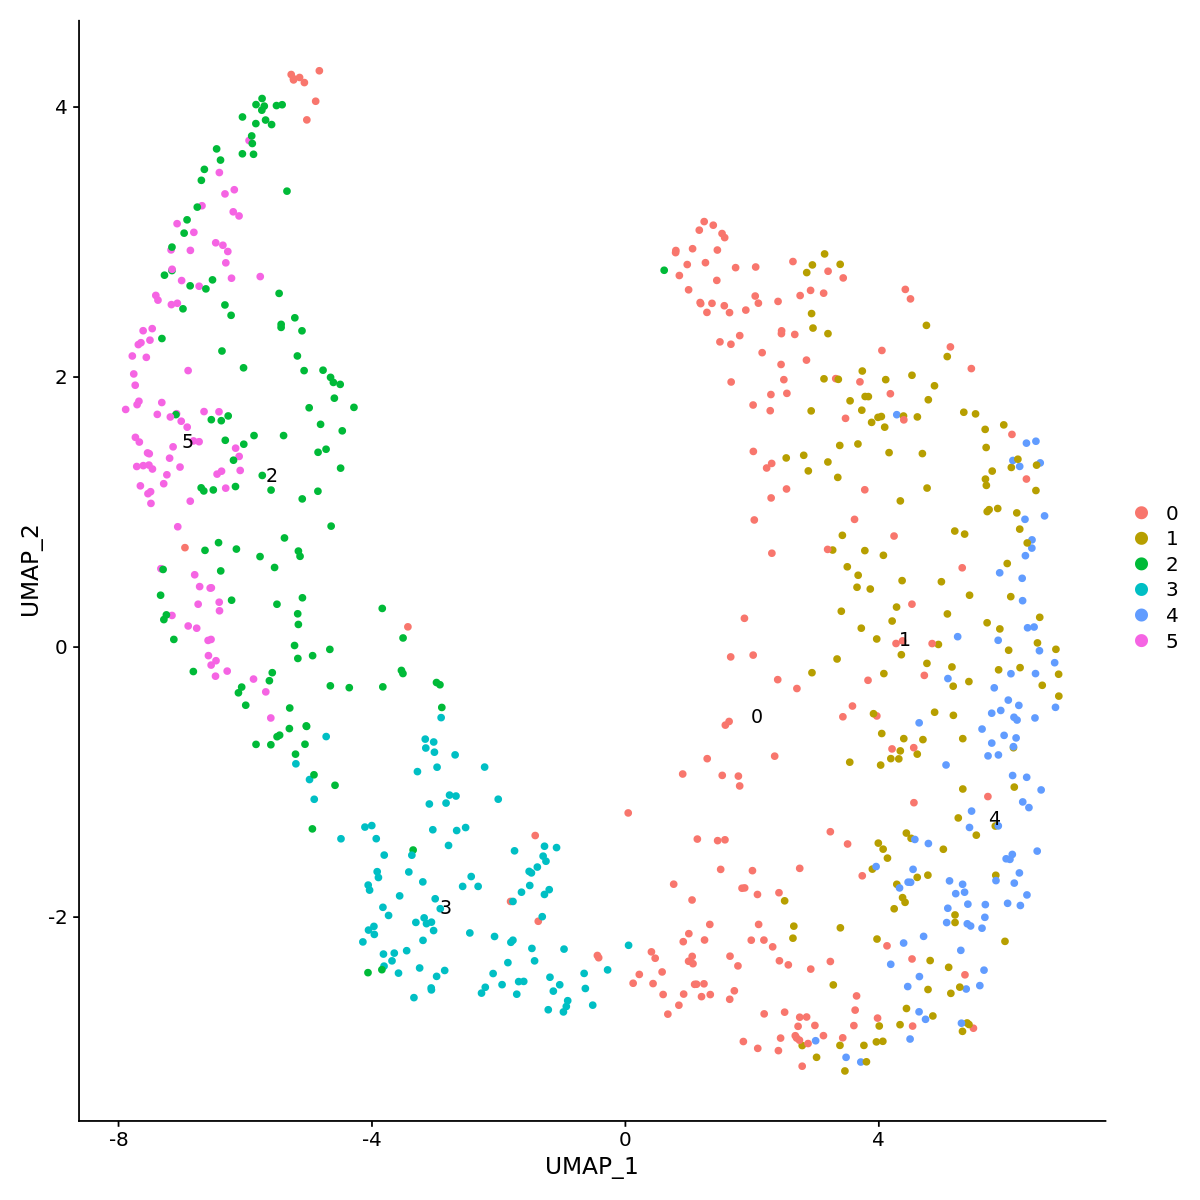

In [11]:
options(repr.plot.width= 10, repr.plot.height=10)
DimPlot(seu_intd_wt_AZ, reduction = "umap", label = TRUE, pt.size = 1.5)

In [39]:
DefaultAssay(seu_intd_wt_AZ) <- "RNA"

#get pseudobulk for each cluster to compare with kwak data
pbs = list()
count = 1
for (l in levels(seu_intd_wt_AZ@meta.data$seurat_clusters)) {
    #print(l)
    #print(length(WhichCells(seu_intd_wt_AZ, ident = l)))
    pbs[[count]] = rowSums(as.matrix(GetAssayData(seu_intd_wt_AZ, slot = "counts")[,WhichCells(seu_intd_wt_AZ, ident = l)])) 
    #print(WhichCells(seu_intd_wt_AZ, ident = l))
    #print(as.matrix(GetAssayData(seu_intd_wt_AZ, slot = "counts")))
    count = count + 1
}

#saveRDS(pbs, "../data/counts/AZ_wt_cluster_pbs_3_1_22")

In [40]:
#convert pseudobulk to TPM
count = 1
for (c in pbs) {
    pbs[[count]] = data.frame(pbs[[count]])/sum(data.frame(pbs[[count]]))*1000000
    rns = rownames(pbs[[count]])
    pbs[[count]] = pbs[[count]][order(rns),, drop = FALSE]
    count = count + 1
}

In [41]:
#secession
kwak_ptpms_raw=read.csv("../data/counts/kwak_ptpms.csv")
rownames(kwak_ptpms_raw) = kwak_ptpms_raw$X
kwak_ptpms = kwak_ptpms_raw
kwak_ptpms[,c(1,3,4)] =NULL
head(kwak_ptpms)

,sec_ptpm
,<dbl>
AT1G01010,20.8020393
AT1G01020,26.7579820
AT1G01030,0.1036921
AT1G01040,2.7690628
AT1G01050,25.6700581
AT1G01060,6.1236542


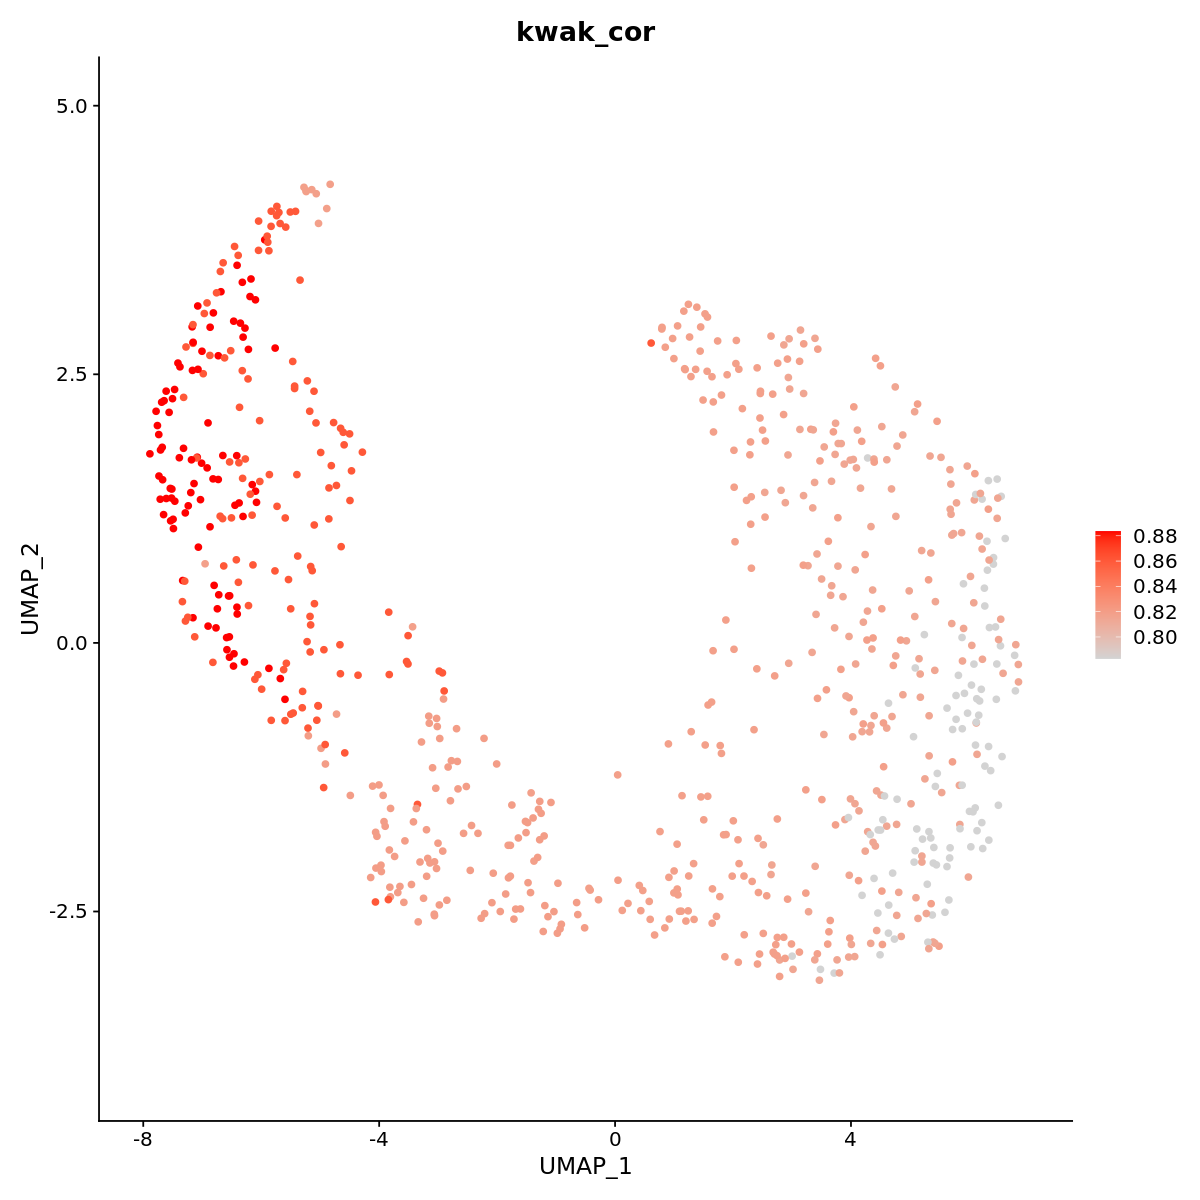

In [42]:
#secession
#set dataset
dataset = kwak_ptpms
#dataset = carpels
#dataset = fils
#dataset = seps
#dataset = pets

cors_spearman = vector()
count = 1

seu_intd_wt_AZ@meta.data$kwak_cor = NULL

for (cluster in c(1:length(levels(seu_intd_wt_AZ@meta.data$seurat_clusters)))){
    test = cbind(pbs[[cluster]][intersect(rownames(pbs[[cluster]]), rownames(dataset)),],dataset[intersect(rownames(pbs[[cluster]]), rownames(dataset)),])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

for (i in c(1:length(levels(seu_intd_wt_AZ@meta.data$seurat_clusters)))){
    seu_intd_wt_AZ@meta.data$kwak_cor[seu_intd_wt_AZ@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

plot = FeaturePlot(seu_intd_wt_AZ,  features = "kwak_cor", pt.size = 1.5, cols = c("light gray", "red"))
#png("kwak_cor_wt_2_1_22.png")
print(plot)   
#dev.off() 

In [43]:
#residuum
kwak_ptpms_raw=read.csv("../data/counts/kwak_ptpms.csv")
rownames(kwak_ptpms_raw) = kwak_ptpms_raw$X
kwak_ptpms = kwak_ptpms_raw
kwak_ptpms[,c(1,2,4)] =NULL
head(kwak_ptpms)

,res_ptpm
,<dbl>
AT1G01010,2.622094
AT1G01020,37.113329
AT1G01030,0.000000
AT1G01040,2.690908
AT1G01050,395.092841
AT1G01060,60.061327


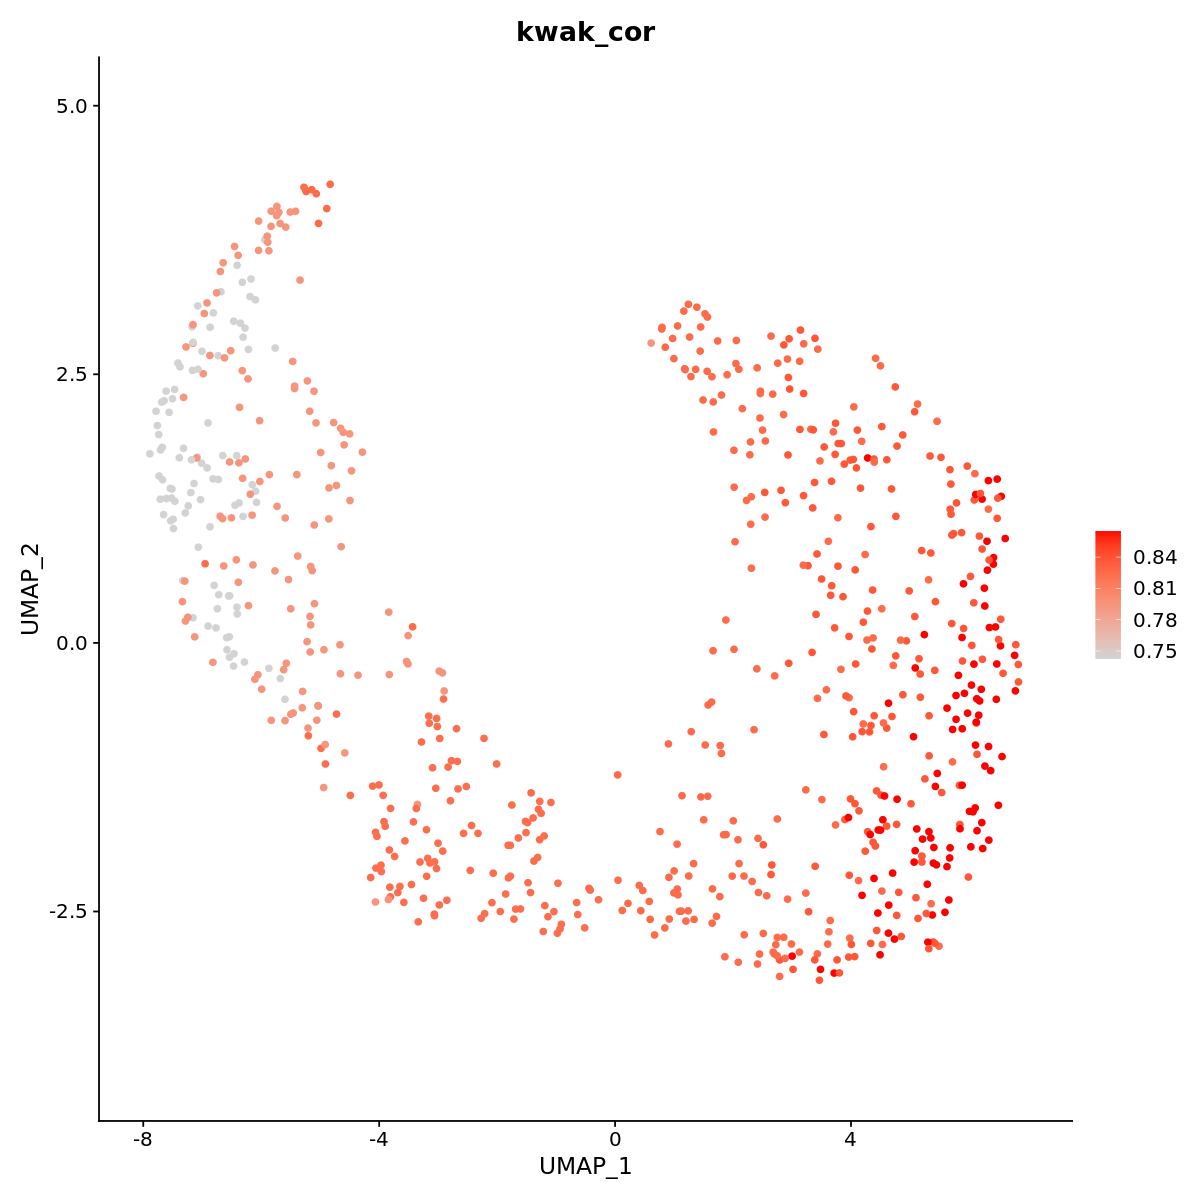

In [44]:
#residuum
#set dataset
dataset = kwak_ptpms
#dataset = carpels
#dataset = fils
#dataset = seps
#dataset = pets

cors_spearman = vector()
count = 1

seu_intd_wt_AZ@meta.data$kwak_cor = NULL

for (cluster in c(1:length(levels(seu_intd_wt_AZ@meta.data$seurat_clusters)))){
    test = cbind(pbs[[cluster]][intersect(rownames(pbs[[cluster]]), rownames(dataset)),],dataset[intersect(rownames(pbs[[cluster]]), rownames(dataset)),])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

for (i in c(1:length(levels(seu_intd_wt_AZ@meta.data$seurat_clusters)))){
    seu_intd_wt_AZ@meta.data$kwak_cor[seu_intd_wt_AZ@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

plot = FeaturePlot(seu_intd_wt_AZ,  features = "kwak_cor", pt.size = 1.5, cols = c("light gray", "red"))
#png("kwak_cor_wt_2_1_22.png")
print(plot)   
#dev.off() 

In [18]:
cluster = "11"

mut_1_AZ <- subset(seu_intd_mut, subset = orig.ident == "sc_27_combined")[, WhichCells(subset(seu_intd_mut, subset = orig.ident == "sc_27_combined"), ident = cluster)]
mut_2_AZ <- subset(seu_intd_mut, subset = orig.ident == "sc_68")[, WhichCells(subset(seu_intd_mut, subset = orig.ident == "sc_68"), ident = cluster)]
KE_1_AZ <- subset(seu_intd_mut, subset = orig.ident == "sc_102")[, WhichCells(subset(seu_intd_mut, subset = orig.ident == "sc_102"), ident = cluster)]
KE_2_AZ <- subset(seu_intd_mut, subset = orig.ident == "sc_104")[, WhichCells(subset(seu_intd_mut, subset = orig.ident == "sc_104"), ident = cluster)]


In [ ]:
mut_1_seu = SCTransform(mut_1_AZ)
mut_2_seu = SCTransform(mut_2_AZ)
KE_1_seu = SCTransform(KE_1_AZ)
KE_2_seu = SCTransform(KE_2_AZ)

In [104]:
seu_intd_mut_AZ = seu_integrate(mut_1_seu, mut_2_seu, KE_1_seu, KE_2_seu, filename = "AZ_only_mut_3_1_22", nfeatures = 3000)

In [21]:
seu_intd_mut_AZ = readRDS("/home/robotmessenger810/sc_analysis/data/intd_seu_objects/AZ_only_mut_3_1_22.rds")

In [22]:
resolution = .5
set.seed(42)
DefaultAssay(seu_intd_mut_AZ) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
seu_intd_mut_AZ <- ScaleData(seu_intd_mut_AZ, verbose = FALSE)
seu_intd_mut_AZ <- RunPCA(seu_intd_mut_AZ, npcs = 100, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

#previously run 20 PCs as of 2/14/22
seu_intd_mut_AZ <- FindNeighbors(seu_intd_mut_AZ, dims = 1:20, verbose = FALSE)
seu_intd_mut_AZ<- FindClusters(seu_intd_mut_AZ, resolution = resolution, algorithm = 3, verbose = FALSE)
seu_intd_mut_AZ <- RunUMAP(seu_intd_mut_AZ, reduction = "pca", dims = 1:20, verbose = FALSE)

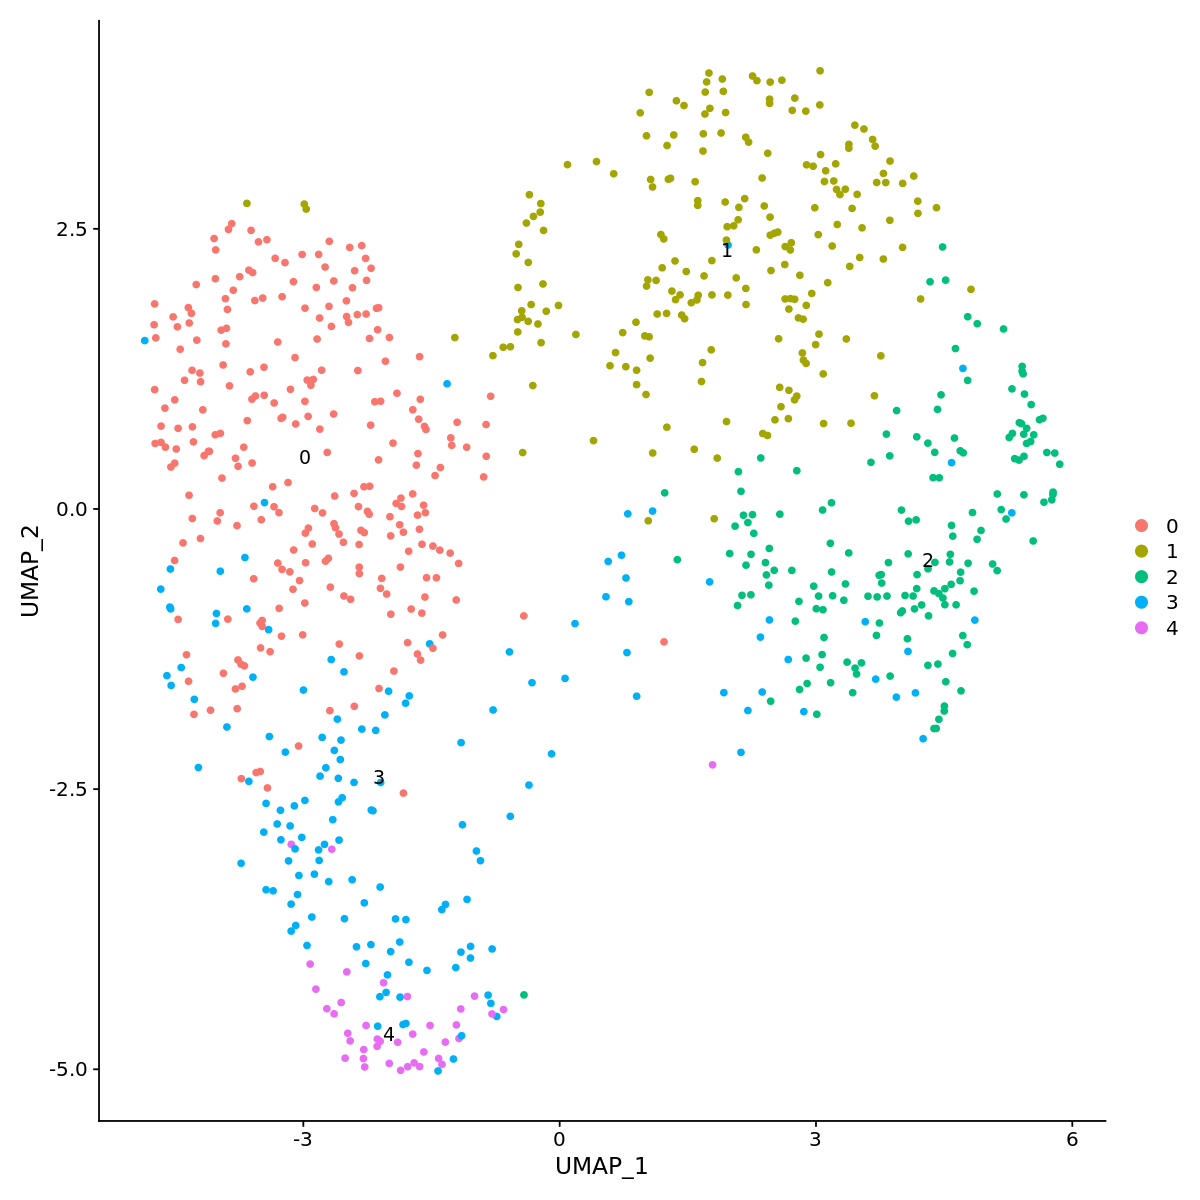

In [23]:
options(repr.plot.width= 10, repr.plot.height=10)
DimPlot(seu_intd_mut_AZ, reduction = "umap", label = TRUE, pt.size = 1.5)

In [48]:
DefaultAssay(seu_intd_mut_AZ) <- "RNA"

#get pseudobulk for each cluster to compare with kwak data
pbs_mut = list()
count = 1
for (l in levels(seu_intd_mut_AZ@meta.data$seurat_clusters)) {
    #print(l)
    #print(length(WhichCells(seu_intd_wt_AZ, ident = l)))
    pbs_mut[[count]] = rowSums(as.matrix(GetAssayData(seu_intd_mut_AZ, slot = "counts")[,WhichCells(seu_intd_mut_AZ, ident = l)])) 
    #print(WhichCells(seu_intd_wt_AZ, ident = l))
    #print(as.matrix(GetAssayData(seu_intd_wt_AZ, slot = "counts")))
    count = count + 1
}

#saveRDS(pbs, "../data/counts/AZ_wt_cluster_pbs_3_1_22")

In [49]:
#convert pseudobulk to TPM
count = 1
for (c in pbs_mut) {
    pbs_mut[[count]] = data.frame(pbs_mut[[count]])/sum(data.frame(pbs_mut[[count]]))*1000000
    rns = rownames(pbs_mut[[count]])
    pbs_mut[[count]] = pbs_mut[[count]][order(rns),, drop = FALSE]
    count = count + 1
}

In [50]:
#secession
kwak_ptpms_raw=read.csv("../data/counts/kwak_ptpms.csv")
rownames(kwak_ptpms_raw) = kwak_ptpms_raw$X
kwak_ptpms = kwak_ptpms_raw
kwak_ptpms[,c(1,3,4)] =NULL
head(kwak_ptpms)

,sec_ptpm
,<dbl>
AT1G01010,20.8020393
AT1G01020,26.7579820
AT1G01030,0.1036921
AT1G01040,2.7690628
AT1G01050,25.6700581
AT1G01060,6.1236542


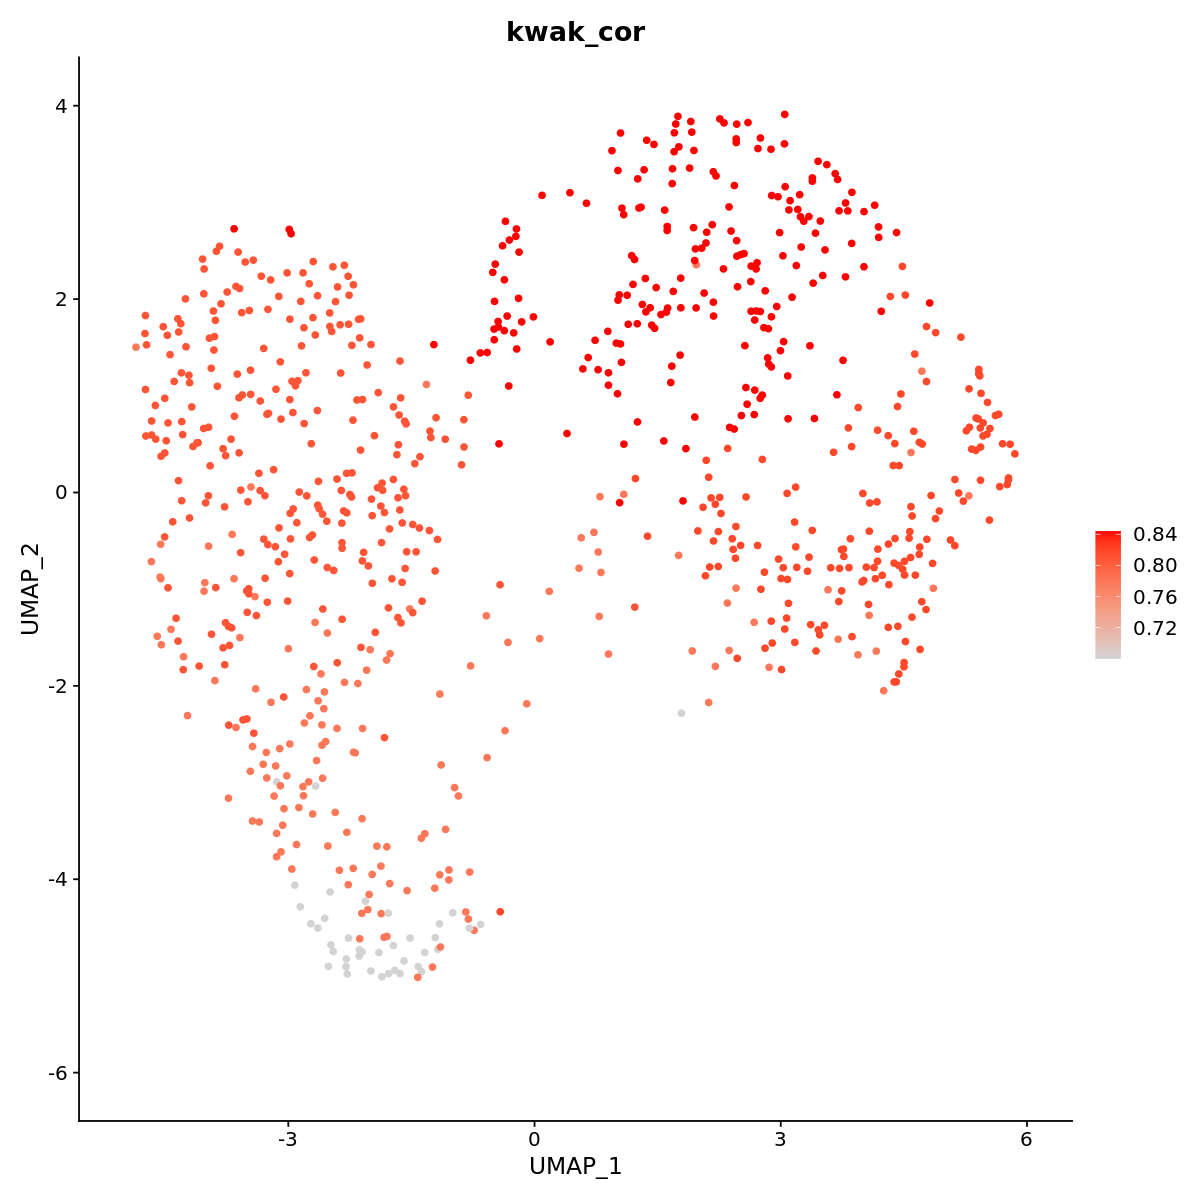

In [51]:
#secession
#set dataset
dataset = kwak_ptpms
#dataset = carpels
#dataset = fils
#dataset = seps
#dataset = pets

cors_spearman = vector()
count = 1

seu_intd_mut_AZ@meta.data$kwak_cor = NULL

for (cluster in c(1:length(levels(seu_intd_mut_AZ@meta.data$seurat_clusters)))){
    test = cbind(pbs_mut[[cluster]][intersect(rownames(pbs_mut[[cluster]]), rownames(dataset)),],dataset[intersect(rownames(pbs_mut[[cluster]]), rownames(dataset)),])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

for (i in c(1:length(levels(seu_intd_mut_AZ@meta.data$seurat_clusters)))){
    seu_intd_mut_AZ@meta.data$kwak_cor[seu_intd_mut_AZ@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

plot = FeaturePlot(seu_intd_mut_AZ,  features = "kwak_cor", pt.size = 1.5, cols = c("light gray", "red"))
#png("kwak_cor_wt_2_1_22.png")
print(plot)   
#dev.off() 

In [52]:
#residuum
kwak_ptpms_raw=read.csv("../data/counts/kwak_ptpms.csv")
rownames(kwak_ptpms_raw) = kwak_ptpms_raw$X
kwak_ptpms = kwak_ptpms_raw
kwak_ptpms[,c(1,2,4)] =NULL
head(kwak_ptpms)

,res_ptpm
,<dbl>
AT1G01010,2.622094
AT1G01020,37.113329
AT1G01030,0.000000
AT1G01040,2.690908
AT1G01050,395.092841
AT1G01060,60.061327


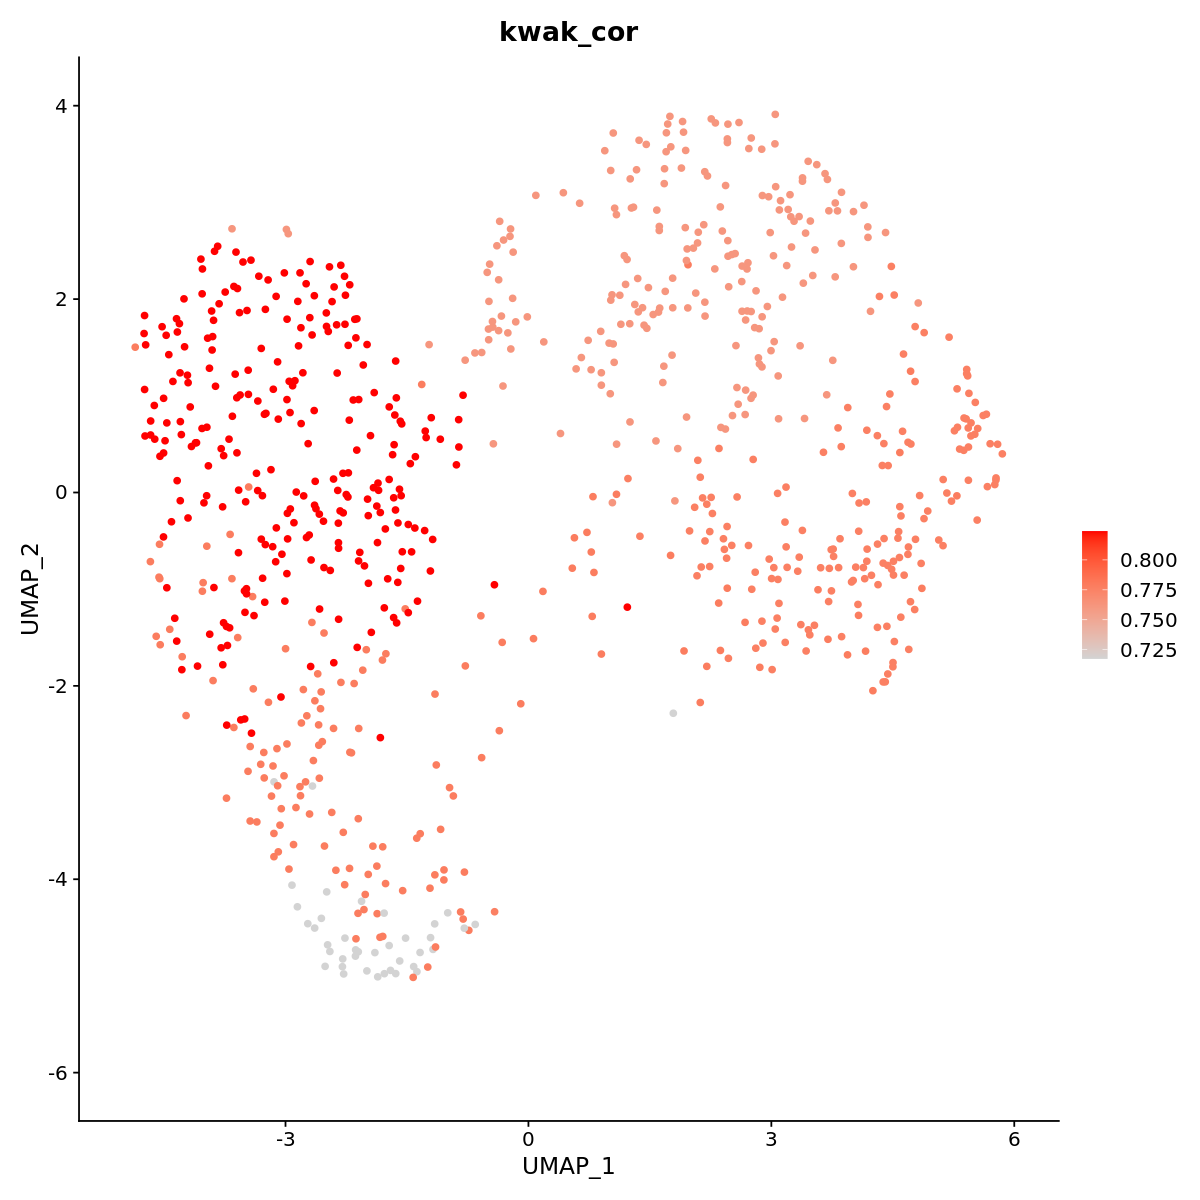

In [53]:
#residuum
#set dataset
dataset = kwak_ptpms
#dataset = carpels
#dataset = fils
#dataset = seps
#dataset = pets

cors_spearman = vector()
count = 1

seu_intd_mut_AZ@meta.data$kwak_cor = NULL

for (cluster in c(1:length(levels(seu_intd_mut_AZ@meta.data$seurat_clusters)))){
    test = cbind(pbs_mut[[cluster]][intersect(rownames(pbs_mut[[cluster]]), rownames(dataset)),],dataset[intersect(rownames(pbs_mut[[cluster]]), rownames(dataset)),])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

for (i in c(1:length(levels(seu_intd_mut_AZ@meta.data$seurat_clusters)))){
    seu_intd_mut_AZ@meta.data$kwak_cor[seu_intd_mut_AZ@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

plot = FeaturePlot(seu_intd_mut_AZ,  features = "kwak_cor", pt.size = 1.5, cols = c("light gray", "red"))
#png("kwak_cor_wt_2_1_22.png")
print(plot)   
#dev.off() 

In [ ]:
seu_intd_all_AZ = seu_integrate(wt_1_seu, wt_2_seu, YFP_1_seu, YFP_2_seu, mut_1_seu, mut_2_seu, KE_1_seu, KE_2_seu, filename = "AZ_only_all_3_2_22", nfeatures = 3000)

In [32]:
resolution = .5
set.seed(42)
DefaultAssay(seu_intd_all_AZ) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
seu_intd_all_AZ <- ScaleData(seu_intd_all_AZ, verbose = FALSE)
seu_intd_all_AZ <- RunPCA(seu_intd_all_AZ, npcs = 100, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

#previously run 20 PCs as of 2/14/22
seu_intd_all_AZ <- FindNeighbors(seu_intd_all_AZ, dims = 1:20, verbose = FALSE)
seu_intd_all_AZ<- FindClusters(seu_intd_all_AZ, resolution = resolution, algorithm = 3, verbose = FALSE)
seu_intd_all_AZ <- RunUMAP(seu_intd_all_AZ, reduction = "pca", dims = 1:20, verbose = FALSE)

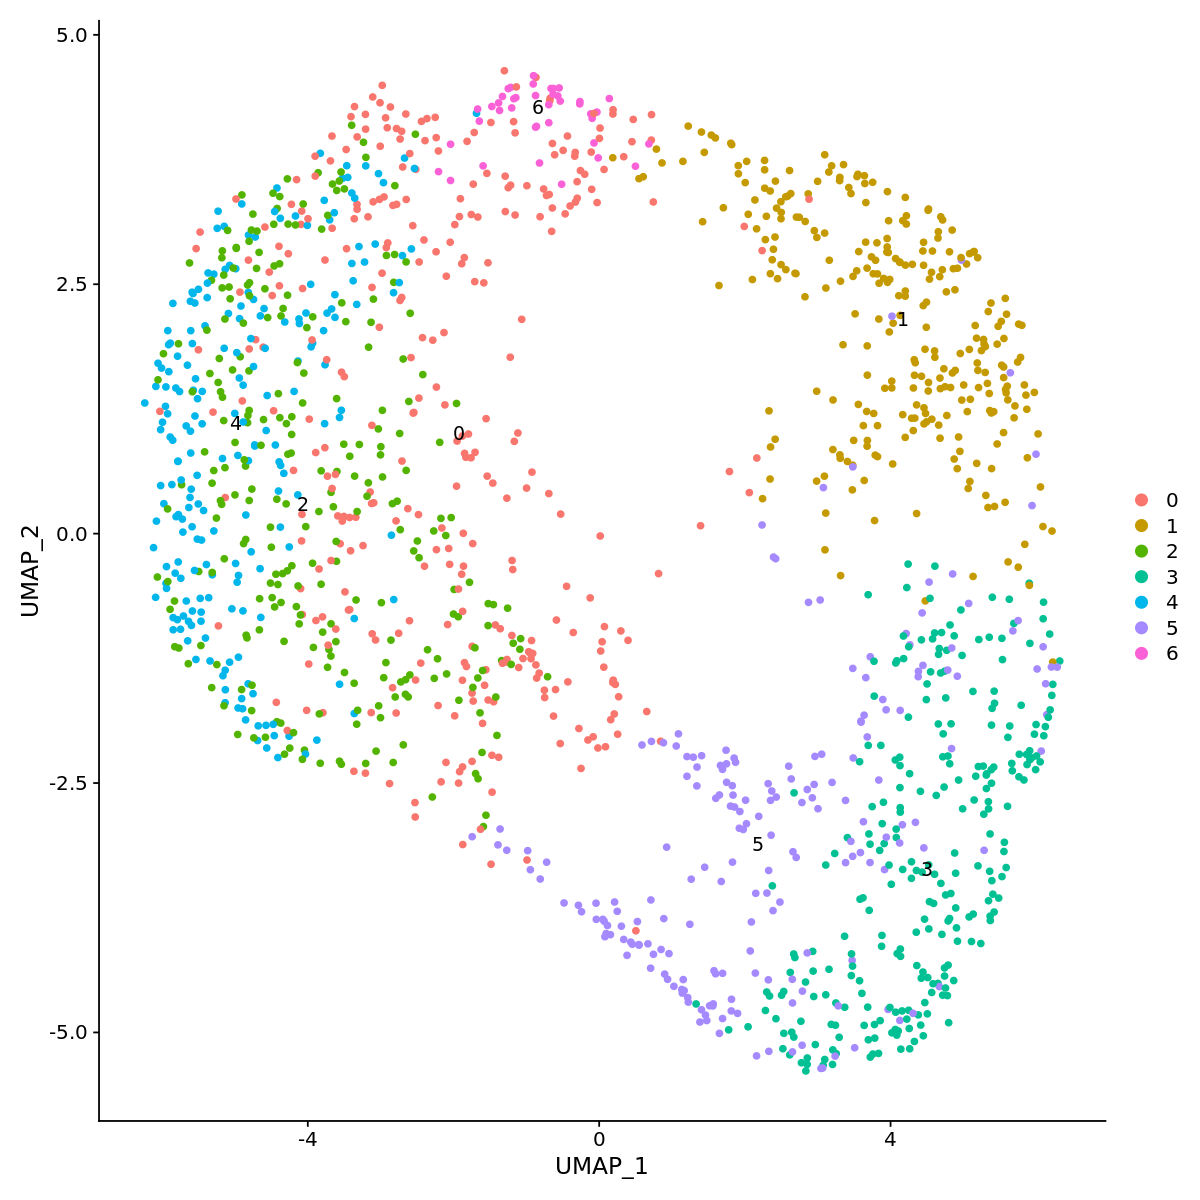

In [34]:
options(repr.plot.width= 10, repr.plot.height=10)
DimPlot(seu_intd_all_AZ, reduction = "umap", label = TRUE, pt.size = 1.5)

In [54]:
DefaultAssay(seu_intd_all_AZ) <- "RNA"

#get pseudobulk for each cluster to compare with kwak data
pbs_all = list()
count = 1
for (l in levels(seu_intd_all_AZ@meta.data$seurat_clusters)) {
    #print(l)
    #print(length(WhichCells(seu_intd_wt_AZ, ident = l)))
    pbs_all[[count]] = rowSums(as.matrix(GetAssayData(seu_intd_all_AZ, slot = "counts")[,WhichCells(seu_intd_all_AZ, ident = l)])) 
    #print(WhichCells(seu_intd_wt_AZ, ident = l))
    #print(as.matrix(GetAssayData(seu_intd_wt_AZ, slot = "counts")))
    count = count + 1
}

#saveRDS(pbs, "../data/counts/AZ_wt_cluster_pbs_3_1_22")

In [55]:
#convert pseudobulk to TPM
count = 1
for (c in pbs_all) {
    pbs_all[[count]] = data.frame(pbs_all[[count]])/sum(data.frame(pbs_all[[count]]))*1000000
    rns = rownames(pbs_all[[count]])
    pbs_all[[count]] = pbs_all[[count]][order(rns),, drop = FALSE]
    count = count + 1
}

In [56]:
#secession
kwak_ptpms_raw=read.csv("../data/counts/kwak_ptpms.csv")
rownames(kwak_ptpms_raw) = kwak_ptpms_raw$X
kwak_ptpms = kwak_ptpms_raw
kwak_ptpms[,c(1,3,4)] =NULL
head(kwak_ptpms)

,sec_ptpm
,<dbl>
AT1G01010,20.8020393
AT1G01020,26.7579820
AT1G01030,0.1036921
AT1G01040,2.7690628
AT1G01050,25.6700581
AT1G01060,6.1236542


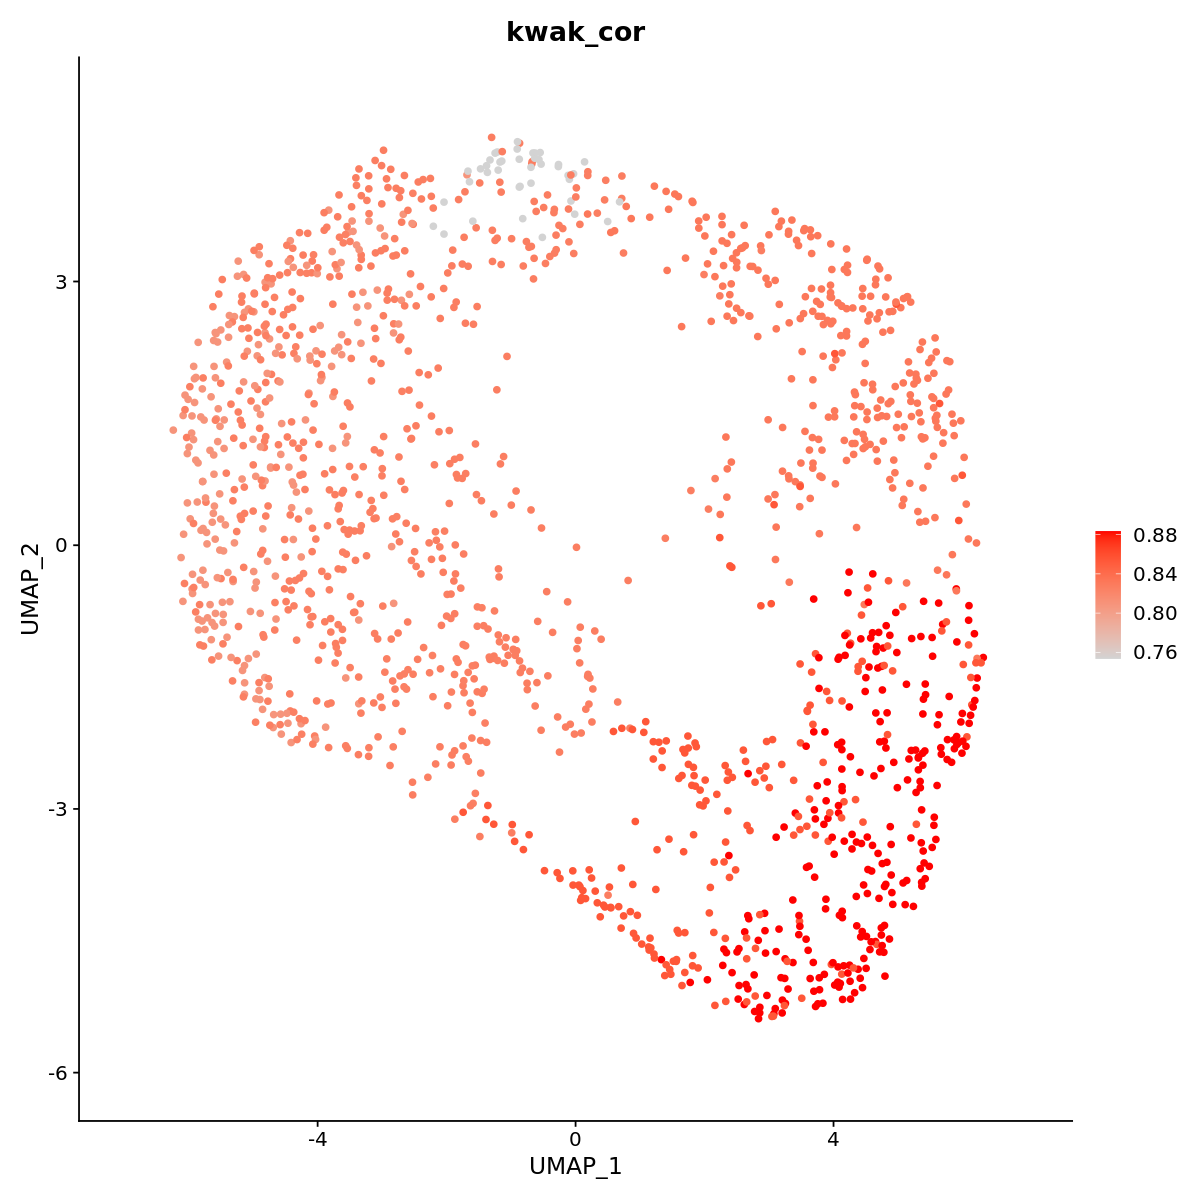

In [57]:
#secession
#set dataset
dataset = kwak_ptpms
#dataset = carpels
#dataset = fils
#dataset = seps
#dataset = pets

cors_spearman = vector()
count = 1

seu_intd_all_AZ@meta.data$kwak_cor = NULL

for (cluster in c(1:length(levels(seu_intd_all_AZ@meta.data$seurat_clusters)))){
    test = cbind(pbs_all[[cluster]][intersect(rownames(pbs_all[[cluster]]), rownames(dataset)),],dataset[intersect(rownames(pbs_all[[cluster]]), rownames(dataset)),])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

for (i in c(1:length(levels(seu_intd_all_AZ@meta.data$seurat_clusters)))){
    seu_intd_all_AZ@meta.data$kwak_cor[seu_intd_all_AZ@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

plot = FeaturePlot(seu_intd_all_AZ,  features = "kwak_cor", pt.size = 1.5, cols = c("light gray", "red"))
#png("kwak_cor_wt_2_1_22.png")
print(plot)   
#dev.off() 

In [30]:
#takes a list of Seurat objects with SCT transform run
seu_integrate <- function(..., filename, nfeatures){
    seu.list <- list(...) # THIS WILL BE A LIST STORING EVERYTHING:
    
    ref.genes = rownames(seu.list[[1]]@assays$RNA)
    assay_list <- rep("SCT", length(seu.list))
# loop
#    for (i in 1:length(seu.list)) {
#         seu.list[[i]]@assays$spliced_RNA <- NULL
#         seu.list[[i]]@assays$spliced_SCT <- NULL
#         seu.list[[i]]@assays$unspliced_RNA <- NULL
#         seu.list[[i]]@assays$unspliced_SCT <- NULL
        

    # integration
    rc.features <- SelectIntegrationFeatures(object.list = seu.list, nfeatures = nfeatures)
    rc.features <- rc.features[(!c(grepl("ATMG",rc.features) | grepl("ATCG",rc.features) | rc.features%in%proto_list))]
    
    seu.list <- PrepSCTIntegration(object.list = seu.list, anchor.features = rc.features, verbose = TRUE, assay = assay_list)
    seu.list <- lapply(X = seu.list, FUN = RunPCA, verbose = FALSE, features = rc.features)
    rc.anchors <- FindIntegrationAnchors(object.list = seu.list, normalization.method = "SCT", anchor.features = rc.features, verbose = TRUE, reference=1, reduction = "rpca")
    
    to_integrate <- Reduce(intersect, lapply(rc.anchors@object.list, rownames))
    # integrate data and keep full geneset
       
    rc.integrated <- IntegrateData(anchorset = rc.anchors,  features.to.integrate = to_integrate, normalization.method = "SCT", verbose = TRUE)
    rc.integrated <- RunPCA(rc.integrated, npcs = 50, verbose = FALSE, approx = FALSE)
    
    #save object    
    saveRDS(rc.integrated, file = paste("../data/intd_seu_objects/",filename,".rds", sep = ""))
    return(rc.integrated)
#    }
}

